Grover's algorithm, also known as the quantum search algorithm, allows unstructured search that finds with high probability the unique input to a black box function that produces a particular output value, using just $O({\sqrt {N}})$ evaluations of the function, where $N$ is the size of the function's domain.
We run Grover's algorithm on a 2-qubit circuit, the oracle encoding one of the 4 possible quantum states, and verify whether the measuremet outcome corresponds to the input state.

### Import modules

In [1]:
# importing Qiskit
from qiskit import QuantumCircuit, assemble
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from qiskit_textbook.tools import vector2latex

import qiclib as ql
from qiclib.code import *
from qiclib.packages.qiskit.QiController_backend import QiController_backend
from qiclib.packages.qiskit.QiController_provider import QiController_provider

QKIT configuration initialized -> available as qkit.cfg[...]


/home/lukas/Development/qup_client/src/qiclib/packages/qkit_polyfill.py:38: UserWarning: If you intend to use the QiController together with Qkit, do not forget to start it with qkit.start() before creating the QiController instance.
  warnings.warn(


### Call QiController backend Slot3

In [2]:
qic = ql.QiController("slot3-platform")

[QiController] qiclib version: 1.0.0 +66 (d4cbf0e7, 18.09.2024 13:01) <dirty>
[QiController] Establishing remote connection to slot3-platform...
[QiController] Detected QiController running on ZCU111 board
[QiController] Firmware build time: 13.09.2024 14:11:22 (Revision 779E92BA)
[QiController] Firmware with 6 digital unit cells detected.


### Add coupling map of qubits

In [3]:
# Add coupling map of qubits q0 and q1 (or q1 and q0) subject to the CNOT operation
coupling_map = [[0, 1]]

### Define the sample

In [4]:
# Define the sample of 3 cells; 2 cells correspond the 2 qubits of the circuit, and the 3rd cell is used
# for coupling q0 and q1
sample = QiSample(3)

# First cell corresponds to the first qubit of the circuit
sample[0]["rec_pulse"] = 116e-9  # s readout pulse length
sample[0]["rec_length"] = 100e-9  # s recording window size
sample[0]["rec_frequency"] = 60e6  # Hz readout pulse frequency
sample[0]["manip_frequency"] = 80e6  # Hz control pulse frequency
sample[0]["rec_offset"] = 20e-9  # s electrical delay
sample[0]["pi"] = 160e-9  # s Pi pulse duration
sample[0]["T1"] = 2e-6  # s decoherence time
sample[0]["T2"] = 3e-6  # s dephasing time

# Second cell corresponds to the second qubit of the circuit
sample[1]["rec_pulse"] = 116e-9  # s readout pulse length
sample[1]["rec_length"] = 100e-9  # s recording window size
sample[1]["rec_frequency"] = 90e6  # Hz readout pulse frequency
sample[1]["manip_frequency"] = 80e6  # Hz control pulse frequency
sample[1]["rec_offset"] = 20e-9  # s electrical delay
sample[1]["pi"] = 160e-9  # s Pi pulse duration
sample[1]["T1"] = 2e-6  # s decoherence time
sample[1]["T2"] = 3e-6  # s dephasing

# One additional cell to couple the two qubits q0 and q1, and apply the CNOT gate
sample[2]["gauss_on_pulse_length"] = 24e-9  # s
sample[2]["rectangular_pulse_length"] = 132e-9  # s
sample[2]["gauss_off_pulse_length"] = 24e-9  # s
sample[2]["pulse_frequency"] = 854e6  # Hz

### Amplitude calibration

In [5]:
qic.cell[0].manipulation.amplitude_calibration = (0.5, 0.5)
qic.cell[1].manipulation.amplitude_calibration = (0.5, 0.5)

HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1000)

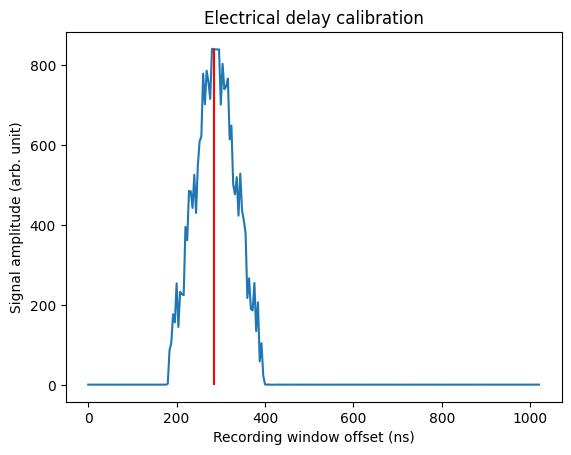

Optimal offset: 284.0 ns


HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1000)

Mirror sideband is -13.9 dB suppressed at recording input


Mirror sideband is 13.86 dB stronger than the actual signal at the recording input. Are maybe I and Q components swapped at the mixer?

HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1000)

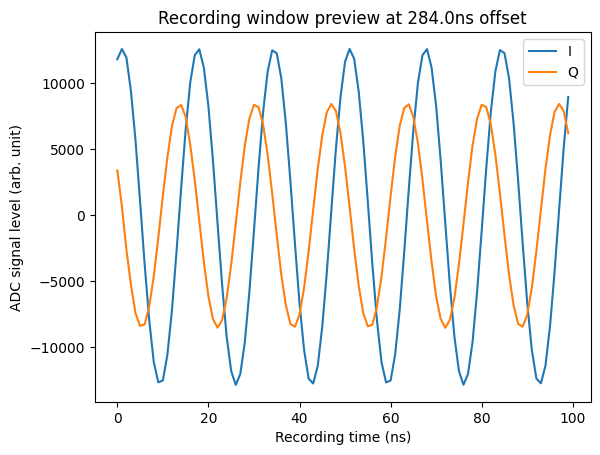

In [6]:
ql.init.calibrate_readout(qic, sample, averages=1000)

In [7]:
with QiJob() as job_test:
    q = QiCells(1)

    ql.jobs.Readout(q[0], "result")

job_test.run(qic, sample, averages=1000, data_collection="iqcloud")

HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1000)

In [8]:
result = job_test.cells[0].data("result")

### State calibration

In [9]:
from qiclib.packages.utility import calculate_stater_config

# Enter the coordinates of the seperation line to each cell of the sample seperately
qic.cell[0].recording.state_config = calculate_stater_config(-4560, -1280, -4530, -1270)
qic.cell[1].recording.state_config = calculate_stater_config(-4560, -1280, -4530, -1270)

### Call QiController provider and define backend

In [10]:
# Call the QiController hardware provider with the specified sample
provider = QiController_provider(qic, sample, coupling_map)

In [11]:
# Create a backend based on the given hardware provider and the sample
backend = QiController_backend(provider)

### Grover's Algorithm

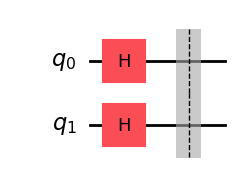

In [13]:
n = 2
grover_circuit = QuantumCircuit(n)

grover_circuit.h(0)
grover_circuit.h(1)
grover_circuit.barrier()

grover_circuit.draw(output="mpl")

Create the oracle encoding the $|10>$ state.

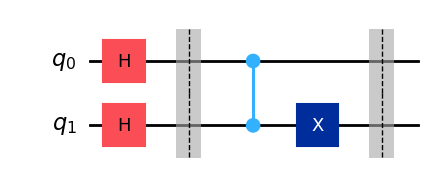

In [14]:
grover_circuit.cz(0, 1)  # Oracle for |11>
grover_circuit.x(1)  # Oracle for |10>
grover_circuit.barrier()
grover_circuit.draw(output="mpl")

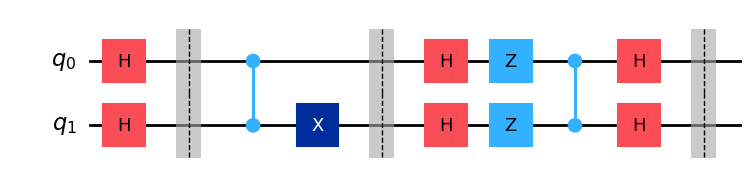

In [15]:
# Diffusion operator (U_s)
grover_circuit.h([0, 1])
grover_circuit.z([0, 1])
grover_circuit.cz(0, 1)
grover_circuit.h([0, 1])
grover_circuit.barrier()
grover_circuit.draw(output="mpl")

the CPhase ($CZ$) gate is not supported by the QiController, so we transpile the grover_circuit to the basis gates {$I, U1, U2, U3, CX$}.

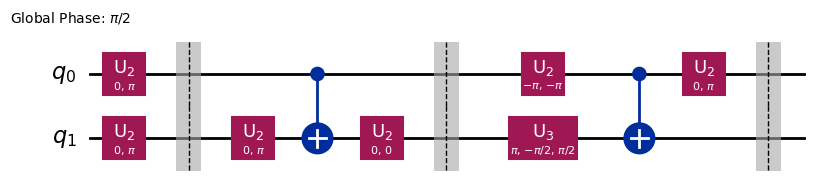

In [16]:
from qiskit.compiler import transpile

transpiled_circuit = transpile(
    grover_circuit, basis_gates=["i", "u1", "u2", "u3", "cx"]
)
transpiled_circuit.draw(output="mpl")

In [17]:
sim = Aer.get_backend("aer_simulator")

# we need to make a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
grover_circuit_sim = transpiled_circuit.copy()
grover_circuit_sim.save_statevector()
qobj = assemble(grover_circuit_sim)
result = sim.run(qobj).result()
statevec = result.get_statevector()

vector2latex(statevec, pretext="|\\psi\\rangle =")

/tmp/ipykernel_113551/1311052545.py:7: DeprecationWarning: The function ``qiskit.compiler.assembler.assemble()`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The `Qobj` class and related functionality are part of the deprecated `BackendV1` workflow,  and no longer necessary for `BackendV2`. If a user workflow requires `Qobj` it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  qobj = assemble(grover_circuit_sim)


TypeError: 'QasmQobj' object is not iterable

In [ ]:
transpiled_circuit.measure_all()

In [ ]:
# Create a job by running the circuit on the backend for a number of shots
job = backend.run(transpiled_circuit, 100)

In [ ]:
# Retrieve the measurement results in terms of counts
counts = job.get_counts()

In [ ]:
print(counts)

In [ ]:
# Display the probability distribution of the quantum states
plot_histogram(counts)